<a href="https://colab.research.google.com/github/conglapgit45/RNN_Hourly_Temperature_Forecasting/blob/main/RNN_Hourly_Temperature_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!gdown --id 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

!unzip /content/dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 139MB/s]
Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


In [4]:
# Read data

dataset_filepath = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']

In [5]:
# Mapping X and y

input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx : feature_end_idx ]
        label = df[label_start_idx : (idx+ window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

In [6]:
# Split data to train, val, test

dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx = 0,
    df_end_idx = train_end_idx,
    input_size = input_size,
    label_size = label_size,
    offset = offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx = train_end_idx,
    df_end_idx = val_end_idx,
    input_size = input_size,
    label_size = label_size,
    offset = offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx = val_end_idx,
    df_end_idx = None,
    input_size = input_size,
    label_size = label_size,
    offset = offset
)

In [7]:
# Build pytorch dataset

class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

In [8]:
# Declare dataloader

train_dataset = WeatherForecast(X_train, y_train)

val_dataset = WeatherForecast(X_val, y_val)

test_dataset = WeatherForecast(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True
)

val_loader = DataLoader (
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False
)
test_loader = DataLoader (
    test_dataset,
    batch_size = test_batch_size,
    shuffle = False
)

In [10]:
# Build model

class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self ).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [12]:
# Declare model

embedding_dim = 1
hidden_size = 8

n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

model = WeatherForecastor(
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    n_layers = n_layers,
    dropout_prob = dropout_prob
).to(device)

Device:  cpu


In [14]:
# Setup loss function and optimizer

lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
# Train model

def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model,
            val_loader,
            criterion,
            device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}: \t Train loss: {train_loss:.4f} \t Val loss: {val_loss:.4f}')

    return train_losses, val_losses


def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc


train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1: 	 Train loss: 126.5261 	 Val loss: 40.6979
EPOCH 2: 	 Train loss: 29.9595 	 Val loss: 7.4822
EPOCH 3: 	 Train loss: 16.1813 	 Val loss: 3.5673
EPOCH 4: 	 Train loss: 13.1765 	 Val loss: 3.0718
EPOCH 5: 	 Train loss: 11.5970 	 Val loss: 2.0178
EPOCH 6: 	 Train loss: 10.7809 	 Val loss: 2.3695
EPOCH 7: 	 Train loss: 10.0049 	 Val loss: 2.7381
EPOCH 8: 	 Train loss: 9.5437 	 Val loss: 2.0497
EPOCH 9: 	 Train loss: 9.4036 	 Val loss: 1.8293
EPOCH 10: 	 Train loss: 9.0557 	 Val loss: 1.9996
EPOCH 11: 	 Train loss: 9.0126 	 Val loss: 1.5838
EPOCH 12: 	 Train loss: 8.7332 	 Val loss: 1.8631
EPOCH 13: 	 Train loss: 8.6026 	 Val loss: 1.9579
EPOCH 14: 	 Train loss: 8.3403 	 Val loss: 1.6885
EPOCH 15: 	 Train loss: 8.2734 	 Val loss: 1.9796
EPOCH 16: 	 Train loss: 8.0663 	 Val loss: 2.1195
EPOCH 17: 	 Train loss: 7.8379 	 Val loss: 1.6398
EPOCH 18: 	 Train loss: 7.7163 	 Val loss: 1.6172
EPOCH 19: 	 Train loss: 7.6191 	 Val loss: 1.6292
EPOCH 20: 	 Train loss: 7.4775 	 Val loss: 1.8229


In [17]:
# Evaluate model

val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val / test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val / test dataset
Val loss:  (1.5434581463844523, 0.005391394504924832)
Test loss:  (1.3666194923376642, 0.006639692914202718)


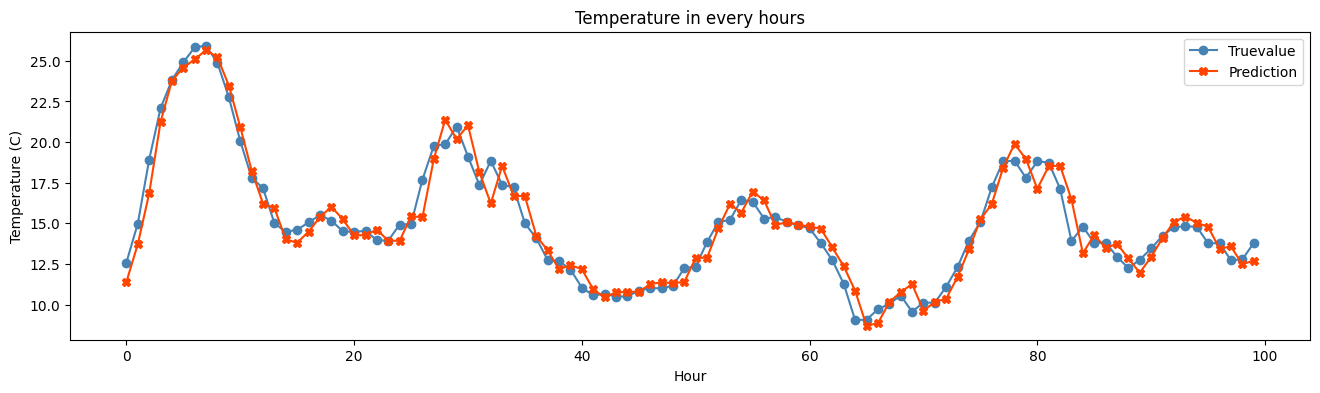

In [22]:
# Visualize result

def plot_difference(y, pred):
    plt.figure(figsize=(16, 4))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker ='o', label='Truevalue')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)